In [1]:
import os
import pysam
import sys
sys.path.append('..//')
import shannon_entropies as sp
import pod5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import line_profiler as lprof
import json
import gc

### Loading and Merging methods

In [2]:
def load_pod5_data(p5_path):
    
    # For some godforsaken reason, pod5 somehow consumes upwards of 6 GiB of memory when this runs, 
    # and it DOES NOT DISSAPEAR. ESLIT'rkjasvkajs;flksarejva;lkrvj
    data_list = []
    with pod5.Reader(p5_path) as pod5_file:
        reads = pod5_file.reads()
        for read in reads:
            seq_id = read.read_id
            signal = read.signal_pa
            freq = read.run_info.sample_rate
            data_dict = {'seq_id': str(seq_id),
                         'signal': signal,
                         'freq': freq}
            data_list.append(data_dict)
    pod5_file.close()
            
    return data_list

#https://pod5-file-format.readthedocs.io/en/latest/reference/api/pod5.reader.html#pod5.reader.ReadRecord

In [3]:
def merge_bam_reads_by_id(bam_list_dict, read_list_dict, consensus_list_dict):
        
    # this code can be made more time efficient and memory-chunking but that's not important rn
    bld = pd.DataFrame(bam_list_dict)
    rld = pd.DataFrame(read_list_dict)
    cld = pd.DataFrame(consensus_list_dict)
    
    merged_data_df = pd.merge(bld, rld, on='seq_id', how='left')
    
    for i in range(len(cld)):
        #merged_data_df.at[]
        indexes = merged_data_df[merged_data_df['ref_name'] == cld['id'][i]].index
        merged_data_df.loc[indexes,'ref_seq'] = cld['seq'][i]
    
    
    data_dict = merged_data_df.to_dict('records')

    return data_dict

In [4]:
def save_by_consensus(merged_dict, savefile_path):
    '''
    Saves reads by consensus in their own individual json files
    '''
    # First, make it a dataframe again
    df = pd.DataFrame(merged_signal_list_dict)
    
    # Make directory
    os.makedirs(savefile_path,exist_ok=True)
    
    
    # then, get the reference names
    consensus_ids = list(df['ref_name'].unique())
    
    # loop through the reference names:
    for consensus_id in consensus_ids:
        # filter the data accordingly:
        consensus = df[df['ref_name'] == consensus_id]
        
        # Condense the data types (Making sure no info is lost)
        consensus.loc[:,'quality']=consensus['quality'].apply(np.int16)
        consensus.loc[:,'len']=consensus['len'].apply(np.int16)
        consensus.loc[:,'ref']=consensus['ref'].apply(np.int16)
        consensus.loc[:,'rev']=consensus['rev'].apply(np.int16)
        consensus.loc[:,'moves']=consensus['moves'].apply(np.asarray)
        consensus.loc[:,'sig_len']=consensus['sig_len'].apply(np.int16)
        consensus.loc[:,'trim_ofs']=consensus['trim_ofs'].apply(np.int16)
        consensus = consensus.reset_index(drop=True)
        # sub method to convert datatypes in a list to a list
        def listconvert(x):
            for i in range(len(x)):
                x[i]=list(x[i])
            return x
        consensus.loc[:,'signal']=consensus['signal'].apply(listconvert)
        consensus.loc[:,'freq']=consensus['freq'].apply(np.float16)
        
        # Get the reference name, sequence, and frequency
        ref_name = consensus['ref_name'][0]
        ref_seq = consensus['ref_seq'][0]
        freq = consensus['freq'][0]
        
        # remove those columns
        del(consensus['ref_seq'])
        del(consensus['ref_name'])
        del(consensus['freq'])
        
        # generate the header and filename
        header = {'ref_seq':ref_seq,'freq':freq}
        filename = "cons_merge__{}.json".format(ref_name)
        
        # generate the filepath
        filepath = savefile_path + filename
        
        # generate the json object with the header and the dataframe
        json_frame = consensus.to_json() # conver dataframe to json
        json_frame = json.loads(json_frame) # convert json back to dict
        json_out = json.dumps([header, json_frame]) # convert list of dicts to json

        del(consensus)
        # if the path exists, overwrite it
        if os.path.exists(filepath):
            os.remove(filepath)
        
        # write the json object
        with open(filepath, 'a') as file:
            file.write(json_out)
            
        file.close()
    # return the savefile path
    return savefile_path    

### Signal Parsing Methods

In [7]:
def map_signal_to_moves(moves_table, offset, signal):
    if (str(signal) == 'nan'):
        return np.asarray([])
    else:
        # Generate an empty list to hold the true moves
        moves = []

        # get the raw moves, beginning after the first index
        raw_moves = list(moves_table[1:])

        # get the stride, beginning before the moves
        stride = moves_table[0]

        # Loop through the raw moves
        for i in range(len(raw_moves)):

            # if the raw move is zero
            if (raw_moves[i] == 0):

                # append n=stride zeroes
                for j in range(stride):
                    moves.append(0)

            # otherwise, append a 1 and then n-1 zeroes
            else:
                moves.append(1)
                for j in range(stride-1):
                    moves.append(0)

        # get the length difference between the signal+offset and the moves
        lendiff = (len(signal)+offset) - len(moves)

        # convert the moves to an array
        moves = np.asarray(moves)

        # pad the moves with zeroes for the offset and the length difference
        moves = np.pad(moves, (offset, lendiff), 'constant')

        # get the indexes where a stride step occurs
        stride_indicies = (np.where(moves == 1)[0])

        # add the last index as the length of the signal
        stride_indicies = np.append(stride_indicies, len(signal))

        # generate empty list to hold per-observation signals
        signal_list = []

        # loop through the stride indexes
        for i in range(len(stride_indicies)-1):

            # get beginning and end indexes
            begindex = stride_indicies[i]
            enddex = stride_indicies[i+1]

            # append the signal that falls between those indexes
            signal_list.append(signal[begindex:enddex])

        # return the list of observed signal segments
        return signal_list

In [8]:
def convert_signal_from_dict(m_list_dict):
    merged_data_df = pd.DataFrame(merged_list_dict)
    merged_data_df['signal'] = merged_data_df.apply(lambda x: map_signal_to_moves(x['moves'], x['trim_ofs'], x['signal']), axis=1)
    end_dict = merged_data_df.to_dict('records')
    del(merged_data_df)
    return end_dict

### Cell containing filepaths

In [2]:
# Load the paths
bam_path = "../../../data/large_working_directory/rough_consensus_output/large_align.bam"
pod5_path = "../../../data/large_working_directory/merged_pod5/merged.pod5"
ref_fasta = "../../../data/reads_large/230725_PZ_lib_v4_r10/fasta/good.fa"
json_dump_path = "../../../data/large_working_directory/rough_consensus_output/json_data/"

### Cells for merging the data and exporting to json files

In [14]:
# Use the shannon entropy methods to load the bam
loaded_bam = sp.load_in_data(bam_path)
print('bamfile memory allocation:{} GiB'.format(sys.getsizeof(loaded_bam)*(9.3132*10**-10)))

bamfile memory allocation:0.00155696587488 GiB


In [15]:
#Load the consensus reference fasta using shannon entropy methods
consens = sp.consensus_formatter(ref_fasta)

print('consensus memory allocation:{} GiB'.format(sys.getsizeof(consens)*(9.3132*10**-10)))

consensus memory allocation:3.1590374400000004e-05 GiB


In [16]:
# Load the pod5 read data using load_pod5_data -- MEMORY LEAK FROM pod5!!!!
dl = load_pod5_data(pod5_path)

print('dl memory allocation:{} GiB'.format(sys.getsizeof(dl)*(9.3132*10**-10)))

dl memory allocation:0.00315675756864 GiB


In [17]:
# Merge the data
merged_list_dict = merge_bam_reads_by_id(loaded_bam, dl, consens)
print('merged dict memory allocation:{} GiB'.format(sys.getsizeof(merged_list_dict)*(9.3132*10**-10)))

merged dict memory allocation:0.00155696587488 GiB


In [18]:
# convert signal to piecewise by observation --- WHY DOES THIS CAUSE A MEMORY LEAK AS WELL?!?!?!?!
merged_signal_list_dict = convert_signal_from_dict(merged_list_dict)
print('merged signal memory allocation:{} GiB'.format(sys.getsizeof(merged_signal_list_dict)*(9.3132*10**-10)))

merged signal memory allocation:0.00155696587488 GiB


In [3]:
save_by_consensus(merged_signal_list_dict, json_dump_path)

NameError: name 'save_by_consensus' is not defined

### Methods for aligning to the reference sequence

In [3]:
def align_observation_ops(cig, sig):
    '''
    align_observation_ops takes in a cigar and list of mapped signals, and then
    aligns the signal by cigar string operations.
    
    Parameters:
    cig: cigar information (a list of cigar touples)
    sig: a list of move-mapped signal data.
    
    Returns: a dataframe containing two series - one for operation, and 
             one for the signal corresponding to the operation. 
    '''
    
    # set up a dummy list to hold observations
    observation_dict_list = []
    
    # set up an indexer to index the operations by
    observation_indexer = 0

    # Loop through each observaiton in the cigar
    for observation in cig:
        
        # Get the observation type and duration
        ob_type = observation[0]
        ob_len = observation[1]
    
        # loop through the observation duration
        for i in range(ob_len):
            
            # insert the observation and the signal corresponding to that observation
            try:
                if ob_type == 2:
                    # The number of deletions correspond to the difference in signal count, so 
                    # a deletion means there is no signal at that observation (somehow)
                    observation_dict = {'operation':str(ob_type),
                                        'signal':None}
                    sig.insert(i+observation_indexer, None)
                    
                    # if it isnt a deletion, append the signal and operation
                else:
                    observation_dict = {'operation':str(ob_type),
                                        'signal':sig[i+observation_indexer]}
                    
            # if the above fails, it's probably because the signal list is empty, so append none.
            except:
                observation_dict = {'operation':str(ob_type),
                                    'signal':None}
                sig.insert(i+observation_indexer, None)

            # append the observation to the dummy list
            observation_dict_list.append(observation_dict)
            
        # index the observation indexer
        observation_indexer += ob_len
        gc.collect()
        
    # convert to a dataframe, and filter the not-so-valuable operations
    obs_df = pd.DataFrame(observation_dict_list)
    valued_operations = obs_df[(obs_df['operation'] != '4') |( obs_df['operation'] != '4')].reset_index(drop='true')
    

    # return the valued operations
    return valued_operations

In [4]:
def shift_to_alignment(ops, sigs, seq, quals, ref_len, r):
    '''
    shift_to_alignment() shifts the alignment of signals, base operations, and qualities to
    their proper corresponding alignment for a signle read. 
    
    Parameters:
    ops: a pandas series of operations extracted from a cigar string on a per-read basis
    sigs: a pandas series of signal lists corresponding to the operations
    seq: the raw read sequence, as a list of chars.
    quals: the qualities of each observed base/operation, as a list.
    ref_len: the length of the reference sequence the read is mapped to, as an int
    r: the reference position the read is aligned to on the reference, as an int
    
    Returns: a list of three dictionaries of reference-aligned bases/operations,
             qualities, and signals. 
    
    '''
    # per-read alignment shifter
    
    # set up a dummy variable to hold the current base position
    base_position = 0
    
    # set up a list of the base keys
    base_keys = np.arange(ref_len).tolist()
    
    # set up empty dictionaries indexed by base position in the reference
    base_dict = {key:[] for key in base_keys}
    qual_dict =  {key:[] for key in base_keys}
    sig_dict = {key:[] for key in base_keys}
    
    # loop through each operation
    for i in range(len(ops)):
        op = ops[i]
        sig = sigs[i]
        
        shifted_bp = base_position + r
        # if it's a 0, we put the corresponding base in that index
        if (op == str(0)):
            # get the base at the base position in the sequence and append it,
            # likewise do the same for quality and signal
            base_dict[shifted_bp].append(seq[base_position])
            qual_dict[shifted_bp].append(quals[base_position])
            sig_dict[shifted_bp].append(sig)
            
            #index the base position by 1
            base_position += 1
        
        # if it's a 1, we have an insertion at that index
        elif (op == str(1)):
            
            # append the insertion indexer into the previous base position
            base_dict[shifted_bp-1].append("+")
            
            # append the quality to the previous base position
            qual_dict[shifted_bp-1].append(quals[base_position])
            
            # append the signal to the previous base position
            sig_dict[shifted_bp-1].append(sig)
            
            # delete the inserted base and quality to not get indexing errors
            del(seq[base_position])
            del(quals[base_position])
        
        # if it's a deletion,
        elif(op == str(2)):
            
            # insert a deletion indexer into the sequence and signals
            seq.insert(base_position, "-")
            quals.insert(base_position, None)
            
            # append the signal
            sig_dict[shifted_bp].append(sig)
            
            #append the deletion base
            base_dict[shifted_bp].append("-")
            
            # index the base position
            base_position += 1
            
            
    return [base_dict, qual_dict, sig_dict]

In [5]:
def parse_read_alignment_info(signal, cigar, ref_pos, qualities, read_sequence, reference_sequence):
    '''
    parse_read_alignment_info is used to prepare read data to be aligned to a reference,
    and then align it and provide the resulting information.
    
    Parameters:
    signal: an array of move-mapped signal lists.
    cigar: a list of touples of corresponding cigar information
    ref_pos: reference position on a read as an int
    qualities: an array of qualities
    read_sequence: a string containing the read sequence of bases
    reference_fasta: a string containing the reference sequence the read was mapped to.
    
    Returns: a list of three dictionaries corresponding to the
             aligned base operations, qualities, and signals.
    '''
    # per-row reader for the alignment info
    
    # Make copies to avoid issues with overwriting data, and ensure datatypes are right.
    sig = list(signal.copy())
    c = cigar.copy()
    r = int(ref_pos)
    q = qualities.copy()
    seq = list(read_sequence) 
    ref_seq_len = len(reference_sequence)
    
    # Align the signals to observations using the eponymous method w/
    # the cigar string, and the signals
    ops_and_signals = align_observation_ops(c, sig)
    
    # isolate the signals and operations:
    o = ops_and_signals['operation'].copy()
    op_sig = ops_and_signals['signal'].copy()
    
    # get the alignment dictionaries as a list of dicts
    dicts = shift_to_alignment(o, op_sig, seq, q, ref_seq_len, r)
    del sig
    del c
    del r
    del q
    del seq
    del ref_seq_len
    
    return dicts

In [6]:
def extract_alignment_from_dict(m_list_dict, r_seq):
    '''
    extract_alignment_from_dict takes in a list of dictionaries of merged information,
    and the reference sequence for the reads in the list of dictionaries, and 
    then generates the reference-based alignment data.
    
    Parameters:
    m_list_dict: a list of dictionaries of merged read data, all corresponding to a single reference sequence.
                 each dict must have keys [signal, cigar, ref, quality, sequence].
    r_seq: the reference sequence as a str that all reads in the dict correspond to.
    
    Returns:
    a list of dicts containing the data and newly added alignment data as a new key.
    '''
    # extract the alignment info from the merged dict
    e_df = pd.DataFrame(m_list_dict)
    
    # apply parse_read_alignment_info
    e_df['alignment_data'] = e_df.apply(lambda x: parse_read_alignment_info(x['signal'],
                                                                            x['cigar'],
                                                                            x['ref'],
                                                                            x['quality'],
                                                                            x['sequence'],
                                                                            r_seq), axis = 1)
    # convert back to a dict
    out_dict = e_df.to_dict("records")
    
    # delete the dataframe
    del(e_df)
    
    # collect the garbage.
    gc.collect()
    
    # return the dict.
    return out_dict

### Loading from json

In [7]:
def load_info_from_json(path):
    '''
    load_info_from_json loads the information from a consensus json file that
    was exported from merge_consensus.py's save_by_consensus(),
    and provides them as a handful of variables.
    
    Parameters:
    path: path, as str, to the consensus json file.
    
    Returns:
    consensus_id, data_dict, ref_seq, freq,
        consensus_id - the id of the consensus sequence
        data_dict - list of dicts of all the reads' data in the file
        ref_seq - the reference sequence as a string
        freq - sampling frequency of the reads in the file
    '''
    
    # create a dummy variable to hold the data
    data = None
    
    # parse the consensus id from the filename
    consensus_id = path.split('__')[-1].split(".")[0]
    
    # open the file
    with open(path) as f:
        # load the data from json
        data = json.load(f)
        
    # close the file
    f.close()
    
    # get the reference sequence from the header
    ref_seq = data[0]['ref_seq']
    
    # get the frequency from the header
    freq = data[0]['freq']
    
    # get the data 
    data_dict = data[1]
    
    gc.collect()
    # return the information extracted.
    return consensus_id, data_dict, ref_seq, freq

In [8]:
json_file_names = os.listdir(json_dump_path)

In [9]:
consensus_id, data_dict, ref_seq, freq = load_info_from_json(json_dump_path + json_file_names[0])

In [10]:
read_alignment_data = extract_alignment_from_dict(data_dict, ref_seq)

In [11]:
read_alignment_df = pd.DataFrame(read_alignment_data)

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(read_alignment_df, test_size=0.3)

In [13]:
train_sub1, train_sub2 = train_test_split(train, test_size=.5)

In [14]:
def extract_coordinate_data(alignment_data):
    '''
    extract_coordinate_data() takes in the alignment data (a pandas series 
    containing a list of three datasets per entry) and then extracts the data to individual
    pandas series.
    
    Parameters:
    alignment_data: a pandas series containing lists of three lists of dicts where
    keys are bases and values are, in order, bases, qualities, and signals. Note: This could probably
    be done in a more storage-efficient format.
    
    Returns:
    a list containing three dataframes of consensus-aligned bases, qualities, and signals
    '''
    
    # convert the alignment data to a dataframe
    df = pd.DataFrame(alignment_data.to_list(), columns=['bases','qualities','signals'])
    
    # assign each dict in the dataframe to its own dataframe
    base_coordinate_df = pd.DataFrame(list(df['bases']))
    qual_coordinate_df = pd.DataFrame(list(df['qualities']))
    signal_coordinate_df = pd.DataFrame(list(df['signals']))
    
    # memory stuff
    del(df)
    
    # create a list to contain the dataframes
    data_out = [base_coordinate_df, qual_coordinate_df, signal_coordinate_df]
    
    # more garbage collection
    del(base_coordinate_df)
    del(qual_coordinate_df)
    del(signal_coordinate_df)
    gc.collect()
    
    # return the dataframe list.
    return data_out

In [15]:
def calc_base_probs(sequence_coordinates):
    """
    base_probs takes in a dataframe of base sequence coordinates and calculates the
    numerical probability of each base at each position by the number of occurences.

    Parameters:
    sequence_coordinates: A pandas dataframe where each row is a read, and each
                          column is a base position. Thus, each cell should have
                          a single base, as a string.

    Returns:
    a dataframe containing statistical likelyhoods of each base at a given position,
    with base positons as columns and base id's as rows. Has an extra column, n,
    that provides number of sample measurements in that row.
    """
    # convert the sequence coordinate lists to strings
    seq_coords = sequence_coordinates.applymap(lambda x: ''.join(x))
    
    # Create a list to hold each option for a base
    base_options = ['A', 'G', 'C', 'T', '-', '+']

    # Generate an empty list to hold the probabilities
    list_of_prob_dicts = []
    list_of_obs = []

    # for each column,
    for column in list(seq_coords.columns):
        
        # convert column to a list with each char being unique, positionally
        charlist = list(''.join(seq_coords[column].to_list()))
        
        # convert the charlist to a pandas series
        char_series = pd.Series((x[0] for x in charlist))

        n_obs = len(char_series)
        list_of_obs.append(n_obs)
        
        # get the number of each value in the column as a dictionary
        counts_dict = char_series.value_counts().to_dict()

        # Loop through each option in the base options
        for option in base_options:

            # if the option isn't in the counts dictionary, set the value to zero
            if option not in counts_dict:
                counts_dict[option]=0

        # Sum up the amount of the base
        total = sum(counts_dict.values(), 0.0)

        probs_dict = {}

        # Add each base to the probability dictionaries
        for i in range(len(counts_dict)):
            key = list(counts_dict.keys())[i]
            value = list(counts_dict.values())[i]
            try:
                probs_dict[key] = value/total
            except:
                probs_dict[key] = None
            
        # append the probability dictionary of the bases to the list
        list_of_prob_dicts.append(probs_dict)

    # convert the list of dicts to a dataframe
    return_df = pd.DataFrame(list_of_prob_dicts)
    return_df['n']=pd.Series(list_of_obs)
    
    gc.collect()
    # Return the dataframe
    return return_df

In [16]:
def shannon_entropies(base_probs):
    """
    shannon_entropies takes in a dataframe with base options as columns and
    the base positions as rows, with the values being probability of each 
    base option at each position, and reuturns the shannon entropies
    of each position in the sequence.

    Parameters:
    base_probs: dataframe containing probabilities as described above

    Returns:
    a series of entropy at each position.
    """

    # Create a duplicate of the base probabilities so no overlapping
    # transforms. 
    tmp_df = base_probs.copy()

    # Set up a list for the base options
    base_options = ['A', 'G', 'C', 'T', '-', '+']

    n_col = tmp_df['n']
    tmp_df = tmp_df.drop(columns=['n'])
    tmp_df = tmp_df.fillna(value=np.nan)

    # loop through each base option in the probabilities
    for column in list(tmp_df.columns):

        # get the series of the column
        base_ser = tmp_df[column]

        # Compute the individual shannon entropy of the column
        tmp_df[column] = base_ser*np.log2(base_ser)

    # Sum all of the shannon entropies for each row, and *-1 to make them positive.
    entropy = tmp_df.sum(axis=1)*-1
    e_max = entropy.max()
    e_min = entropy.min()
    n_entropy = (entropy - e_min) / (e_max-e_min)

    gc.collect()
    # Return the entropy
    return entropy

In [17]:
def get_first_base(base_list):
    '''
    get the first base in a list of bases.
    '''
    if base_list != []:
        return base_list[0]
    else:
        return ""

In [18]:
def check_base_match(base, refbase):
    '''
    check if a base matches the reference base.
    '''
    if base != "":
        if (refbase == base):
            return 0
        else:
            return 1
    else:
        return None

In [19]:
def mismatch_prob(sequence_coordinates, ref_seq):
    '''
    mismatch_prob checks the aligned reads versus a reference sequence,
    and returns the probability of a mismatch at each base position.
    '''
    
    # get the first base of each observation of each read.
    seq_coords = sequence_coordinates.applymap(lambda x: get_first_base(x))
    
    # loop through each base in the reference sequence
    for i in range(len(ref_seq)):
        
        # get the corresponding column of read bases at that index
        refbase = ref_seq[i]
        
        # check if the bases match
        seq_coords[i] = seq_coords[i].apply(lambda x: check_base_match(x, refbase))
        
    # get the mean value of each, which is also the probability in this instance.
    means = seq_coords.mean()
    
    # return the probabilities.
    return means

In [20]:
def split_to_primes(val_list, n_primes = 3):
    out_list = []
    i = 0
    while len(out_list) < n_primes:
        try:
            out_list.append(val_list[i])
        except:
            out_list.append(None)
        i+=1
    return out_list

In [21]:
def split_coords_to_primes(data_coord, n_primes = 3):
    data_pre_split = data_coord.applymap(lambda x: split_to_primes(x, n_primes))
    out_df = pd.DataFrame(data_pre_split.index, columns=['index'])
    for column in data_pre_split.columns:
        prime_cols = []
        prime_str = ""
        for i in range(n_primes):
            prime_cols.append("{}{}".format(column, prime_str))
            prime_str += "'"
        data_col_split = pd.DataFrame(data_pre_split[column].to_list(), columns=prime_cols)
        out_df = out_df.join(data_col_split)
    del(out_df['index'])
        
    return out_df

In [22]:
data_coordinate_list = extract_coordinate_data(read_alignment_df['alignment_data'])

In [23]:
def convert_coordinates_to_primes(data_coordinate_list):
    prime_list = []
    for raw_feature in data_coordinate_list:
        prime_features = split_coords_to_primes(raw_feature)
        prime_list.append(prime_features)
    return prime_list

In [24]:
prime_data = convert_coordinates_to_primes(data_coordinate_list)

In [25]:
from numpy.fft import fft, ifft

319490.6404141581


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

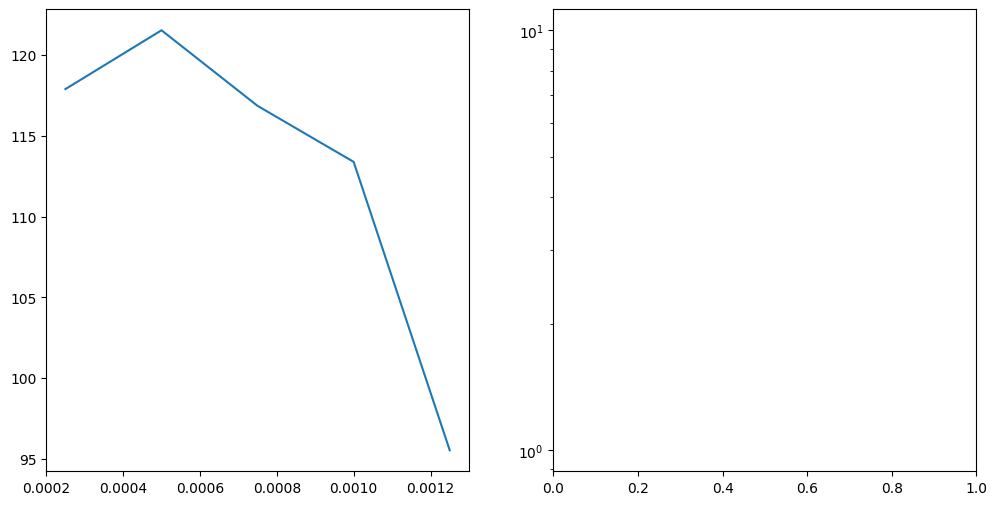

In [53]:
test_sig = prime_data[2]['0'][4]
test_sig = np.asarray(test_sig)
time_step = 1/4000
time = np.full((test_sig.shape)[0], time_step)
time=time.cumsum()

fft = (np.abs(np.fft.fft(test_sig))**2).max()
print(fft)
#fft_freq = print((np.abs(np.fft.fftfreq(len(fft)))**2).max())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(time, test_sig)

axes[1].semilogy(time, fft, 'b')

print(fft)

In [29]:
# base-based features, base_probs is 6 but lets just look at insertions and deletions
# get the alignment coordinate data
data_coordinate_list = extract_coordinate_data(read_alignment_df['alignment_data'])

# get the base probabilites at each position -- THIS HAS INSERTION AND DELETION PERCENTAGE BUILT IN
base_probs = calc_base_probs(data_coordinate_list[0])

# get the probability of mismatch at each position
mismatch_probs = mismatch_prob(data_coordinate_list[0], ref_seq)

# Get the shannon entropy of each base position.
shentropy_series = shannon_entropies(base_probs)

/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'insertion_percent' is not defined

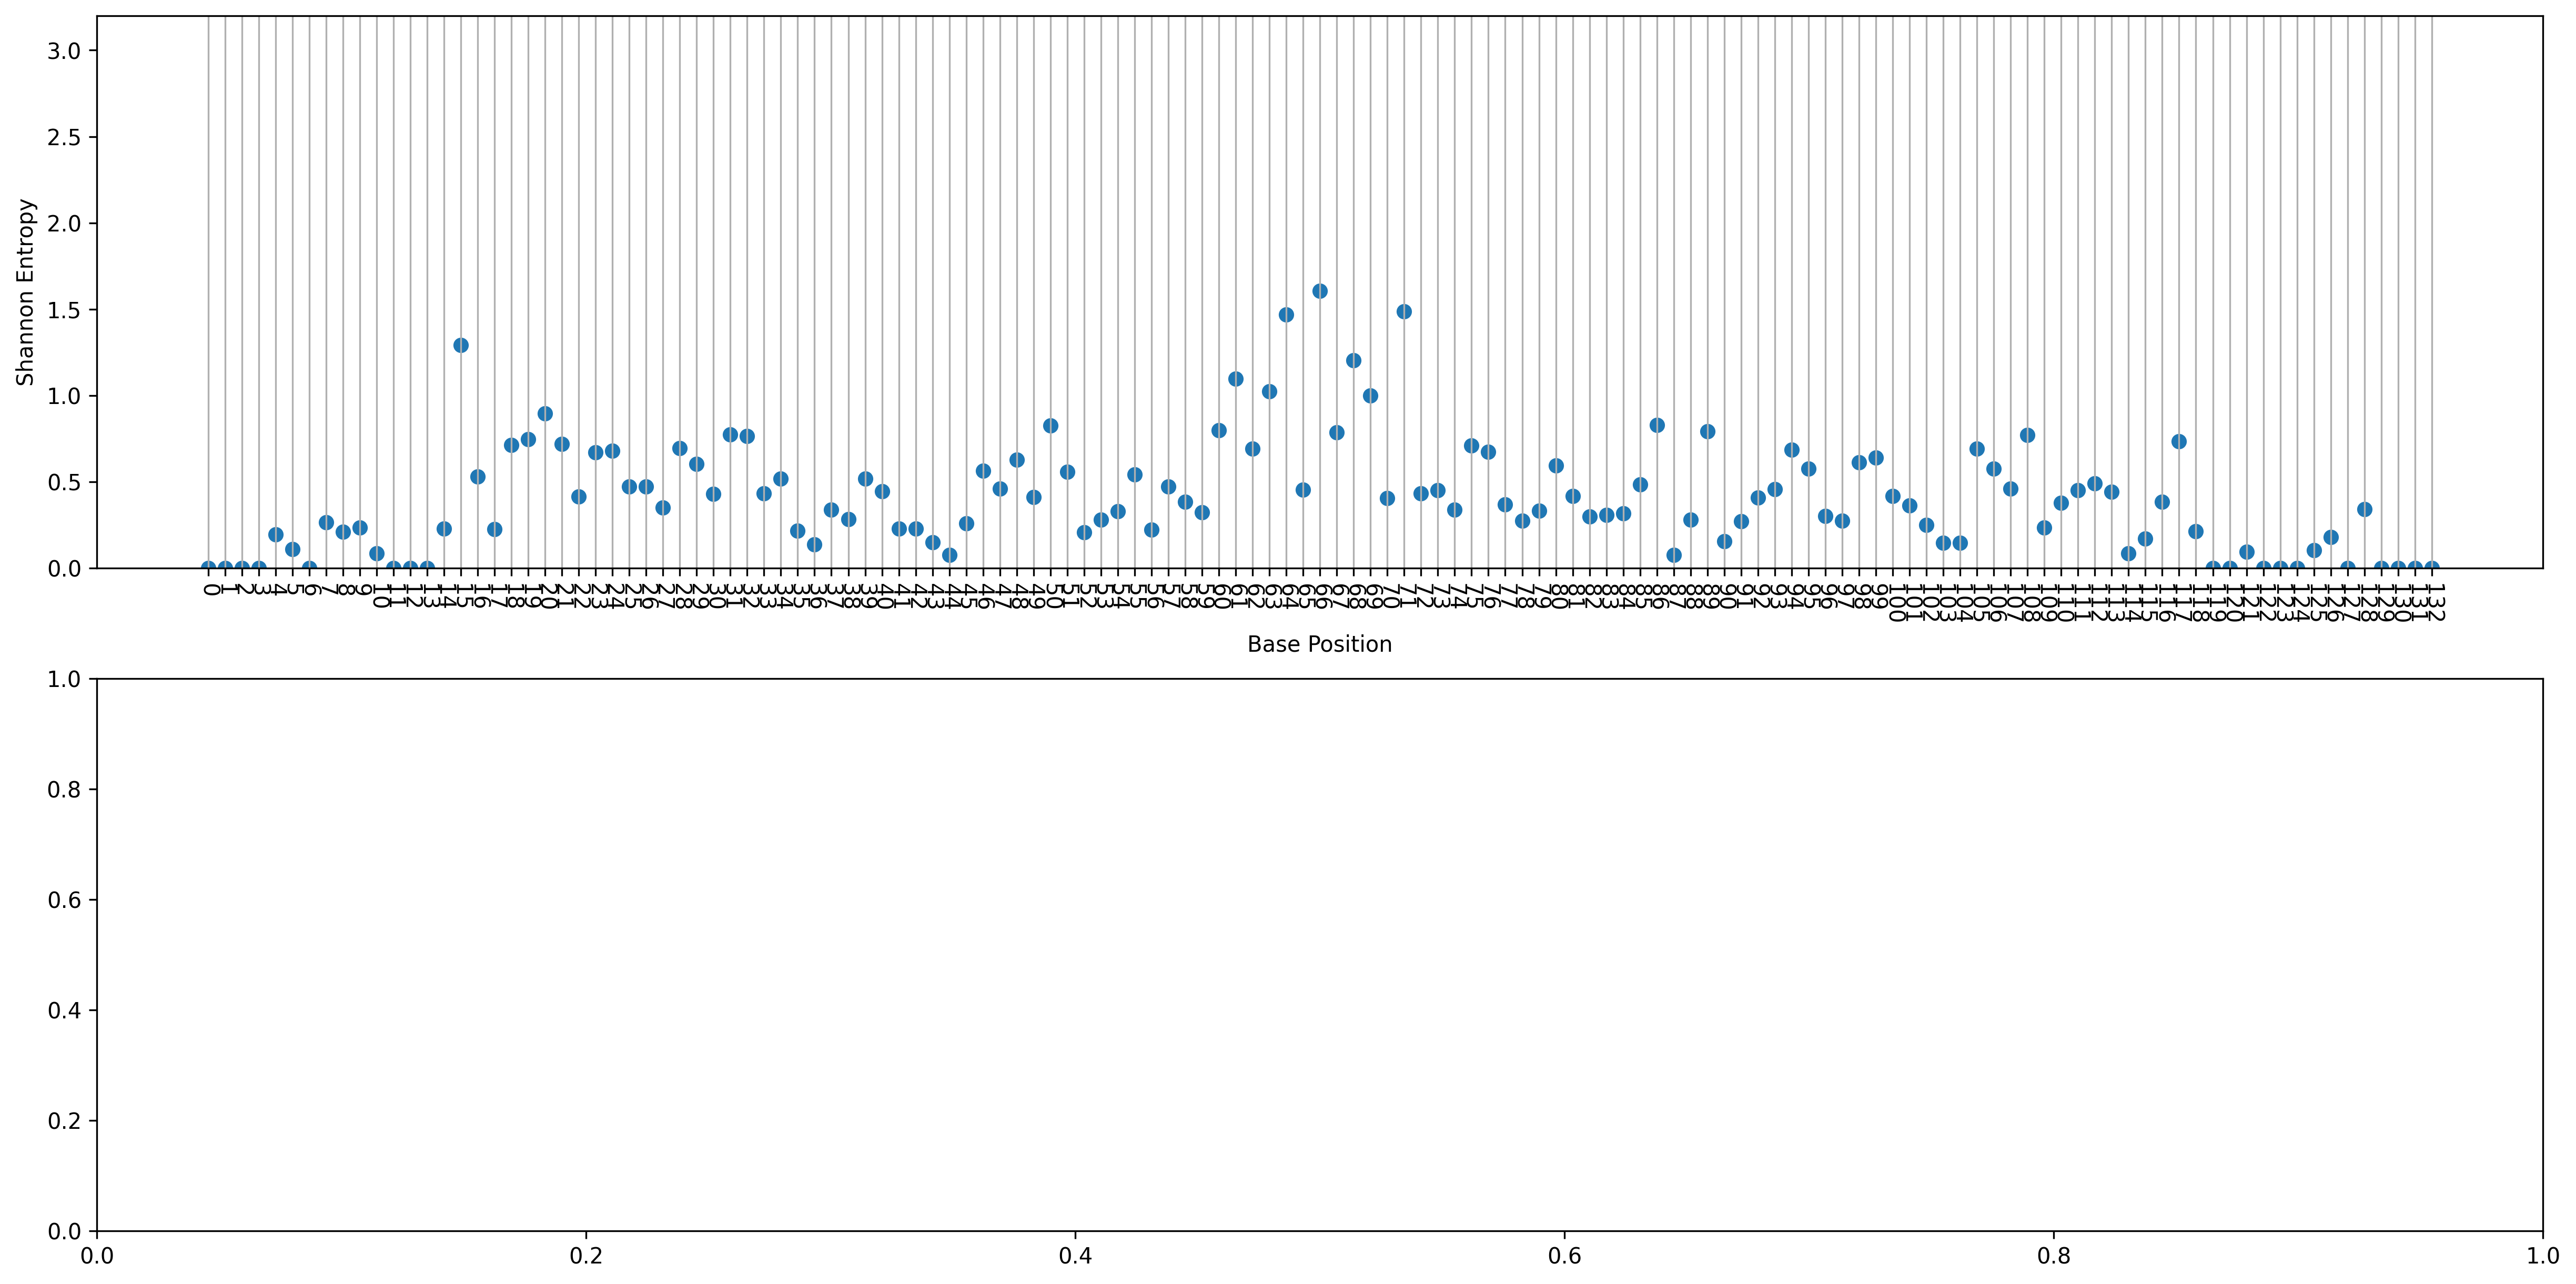

In [30]:
base_indexes = list(map(str, list(shentropy_series.index)))   
entropy = list(shentropy_series.values)
fig, ax = plt.subplots(2, 1, figsize = (20, 10), dpi = 300)
ax[0].scatter(base_indexes, entropy)
ax[0].grid(axis="x")
ax[0].set_ylim(0, 3.2)
ax[0].set_xlabel('Base Position')
ax[0].set_ylabel('Shannon Entropy')
ax[0].tick_params(axis='x',labelrotation=-90)

ax[1].scatter(base_indexes, insertion_percent)
ax[1].scatter(base_indexes, deletion_percent)
ax[1].grid(axis="x")
ax[1].set_xlabel('Base Position')
ax[1].set_ylabel('probability%')
ax[1].legend(['Insertion','Deletion'] )
ax[1].tick_params(axis='x',labelrotation=-90)

In [31]:
def is_in_del(ls_bases):
    
    '''
    is_in_del() takes in a list of bases,
    and checks if the base is an insertion or deletion, 
    and returns a list of booleans corresponding to if the 
    base is either an insertion or deletion.
    
    Parameters:
    ls_bases: a list of bases or operations.
    
    Returns:
    list of booleans corresponding to if the base is an insertion/deletion or not.
    '''
    
    # dummy list to hold booleans
    ls_bools = []
    
    # loop through each base
    for base in ls_bases:
        
        # check if it's an insertion, deletion, or other
        if base == "+":
            ls_bools.append(True)
        elif base == "-":
            ls_bools.append(True)
        else:
            ls_bools.append(False)
            
    # return the list of booleans
    return ls_bools

In [32]:
def filter_by_indel(booleans, values):
    '''
    filter_by_indel() takes in a list of booleans and values (of the same length)
    and returns the values where there was not an insertion or deletion.
    
    Parameters:
    booleans: a list of bools corresponding to i/d or not.
    values: a list of values corresponding to each index in the booleans
    
    Returns: 
    a filtered list to contain only the values at positions that werent insertions or deletions.
    '''
    # generate dummy list for output
    out = []
    
    # loop through the booleans in the list
    for i in range(len(booleans)):
        
        # check if the boolean is not true
        if not booleans[i]:
            
            # append the value at that index
            out.append(values[i])
            
    return out

In [33]:
def remove_in_dels(base_coords, to_filter_coords):
    '''
    remove_in_dels takes in base coordinate dataframe, and a base coordinate dataframe of 
    data to be filtered and then filters that data by if it had insertions/deletions or not
    
    Parameters:
    base_coords: a base coordinate dataframe (columns are index of alignment sequence, rows are reads)
    to_filter_coords: a coordinate dataframe of unknown values to be filtered
    
    Returns:
    a coordinate dataframe with all values corresponding to insertions or deletions removed
    '''
    
    # apply the is_in_del function to each value in the df
    boolmap = base_coords.applymap(lambda x: is_in_del(x))
    
    # copy the filter df
    filter_df = to_filter_coords.copy()
    
    # loop through each column in the dataframe that will be filtered
    for column in to_filter_coords.columns:
        
        # get the transpose of the dataframe that is the combination of the current column of the
        # boolmap and filter_coords
        joined_map = pd.DataFrame([boolmap[column], to_filter_coords[column]]).T
        
        # apply the filteR_by_indel method to each row in this dataframe,
        # and set it to the filter_df's column
        joined_map = joined_map.set_axis(['m', 'q'], axis=1)
        filter_df[column] = joined_map.apply(lambda x: filter_by_indel(x['m'], x['q']), axis=1)
        
    # return the filter df.
    return filter_df
        
        
        

In [34]:
def getmean(lsval):
    '''
    get the mean value from a list of values,
    while checking if it isnt empty, either.
    '''
    if (lsval != []):
        mean = np.mean(np.asarray(lsval))
        return mean
    else:
        return None

In [35]:
def mean_std_qual_by_base(qual_coord):
    '''
    mean_std_qual_by_base() gets the mean and standard deviation quality value by
    the base position.
    
    Parameters:
    qual_coord: coordinate dataframe of qualities of each base in each read mapped to a reference
    
    Returns:
    (meanvals, stdvals, medians) - the means, standard deviations, and median qualities
    as pandas series for each base in the reference sequence
    '''
    
    # apply the getmean method to each cell
    qual_means = qual_coord.applymap(getmean)
    
    # get the mean of each column
    meanvals = qual_means.mean()
    
    # get the std of each column
    stdvals = qual_means.std()
    
    # get the median of each column
    medians = qual_means.median()
            
    # return the mean, std, medians
    return meanvals, stdvals, medians

In [36]:
def get_raw_median(qual_cord):
    '''
    get_raw_median takes in a quality coordinate dataframe,
    and then provides the median quality of each base in the reference.
    
    Parameters:
    qual_cord: quality coordinate dataframe
    
    Returns:
    pandas series of median quality where ALL qualities are involved, not averaging
    qual per base.
    '''
    # empty list for medians
    medians = []
    
    for column in qual_cord.columns:
        # get the series of qualities for the base
        base_qual_ser = qual_cord[column]
        
        # generate an empty list to hold the qualities
        base_qual_list = []
        for i in range(len(base_qual_ser)):
            
            # get the list of qualities for the current base for a specific read
            read_quals = base_qual_ser[i]
            
            for j in range(len(read_quals)):
                # append each observed base for the current read to the list of quals
                base_qual_list.append(read_quals[j])
        # convert to numpy array
        bq_array = np.asarray(base_qual_list)
        med = np.median(bq_array)
        medians.append(med)
        
    return pd.Series(medians)
        
                
                

In [37]:
# quality score features
# get the qualities with no insertions or deletions
no_in_del_qual = remove_in_dels(data_coordinate_list[0], data_coordinate_list[1])

# get the mean, std, and median with no insertions or deletions
no_mvals, no_stvals, no_meanmedian = mean_std_qual_by_base(no_in_del_qual)

# get the mean, std, and median while including insertions or deletions
mvals, stvals, meanmedian = mean_std_qual_by_base(data_coordinate_list[1])

# get the raw median quality score of each base.
rawmeds = get_raw_median(data_coordinate_list[1])

In [38]:
def convert_signals_to_objects(seq_coords, f):
    '''
    convert_signals_to_obects converts each signal value in the sequence coordinates
    to a signal object using the convert_signal_list method.
    
    Parameters:
    seq_coords: read signal coordinate dataframe
    f: sampling frequency as an int. 
    '''
    
    converted = seq_coords.applymap(lambda x: convert_signal_list(x, f))
    return converted

In [89]:
# signal features
class Signal:
    '''
    Signal class is designed to contain and automatically run a handful of valuable pieces
    of information about a signal list, such as mean, std, etc.
    
    
    Parameters:
    signal: list of signal values in picoamperes
    freq: sampling frequency
    
    Methods:
        None
    '''
    def __init__(self, signal, freq):

        # get the mean, std, median, duration, signal, coulombic signal,
        # coulombs moved, mean coulombs, std coulombs, median coulombs
        signal_array = np.asarray(signal)
        self.mean = np.mean(signal_array)
        self.std = np.std(signal_array)
        self.median = np.median(signal_array)
        time_step = 1/freq
        time = np.full((signal_array.shape)[0], time_step)
        self.time = np.sum(time)
        self.signal = signal_array
        self.coulomb_signal = signal_array*time_step
        self.coulombs_moved = self.coulomb_signal.sum()
        self.mean_coulombs_per_step = np.mean(self.coulomb_signal) # per time step
        self.std_coulombs_per_step = np.std(self.coulomb_signal) # per time step
        self.median_coulombs_per_step = np.median(self.coulomb_signal)
        self.fft_peak = (np.abs(np.fft.fft(signal_array))**2).max()
    

In [111]:
class GroupedSignals:
    '''
    GroupedSignals is designed to contain useful methods for processing groups of signal objects.
    '''
    def __init__(self, sig_list):
        '''
        __init__ takes in a list of signal objects and loads the data to relevant variables
        '''
        
        if (type(sig_list) != type(None)):
            self.signal_list = sig_list

            # generate the features of the group.
            self._get_group_features()
            
        else:
            self.signal_list = None
            self.mean_of_means = None
            self.pooled_std = None
            self.total_signal = None
            self.total_signal_mean = None
            self.total_signal_std = None
            self.total_signal_median = None
            
        
        
    def _get_group_features(self):
        '''
        private method for calculating the group features.
        '''
        
        # empty lists for values
        sigmeans = []
        sigstds = []
        total_signal = []
        total_time = 0
        total_coulombs = 0 
        fft_peaks = []
        # loop through each signal in the list
        for signal in self.signal_list:
            total_time += signal.time
            total_coulombs += signal.coulombs_moved
            # get the mean, std, and total signal
            sigmeans.append(signal.mean)
            sigstds.append(np.square(signal.std))
            total_signal.extend(list(signal.signal))
            fft_peaks.append(signal.fft_peak)
            
        # get the mean of means
        mean_of_means = np.mean(np.asarray(sigmeans))
        
        # get pooled standard deviation
        pooled_std = np.sqrt(np.asarray(sigstds).sum()/(len(sigstds)))
        
        # get the total signal and get the mean, std, and median of the total signal
        total_signal = np.asarray(total_signal)
        total_sig_mean = np.mean(total_signal)
        total_sig_std = np.std(total_signal)
        total_sig_median = np.median(total_signal)
        fft_peaks = np.asarray(fft_peaks)
        mean_fft_peak = np.mean(np.asarray(fft_peaks))
        
        # assign to class variables -- should these be calculated on demand rather than stored?
        # yes, but that takes more time we don't have rn.
        self.mean_of_means = mean_of_means
        self.pooled_std = pooled_std
        self.total_signal = total_signal
        self.total_signal_mean = total_sig_mean
        self.total_signal_std = total_sig_std
        self.total_signal_median = total_sig_median
        self.total_fft_peak = (np.abs(np.fft.fft(total_signal))**2).max()
        self.mean_fft_peaks = mean_fft_peak
        self.residence_time = total_time
        
        
        
        
        #### MORE GO BELOW, DONT KNWO WHAT YET
        
        return None
    

In [112]:
def convert_signal_list(sig_list, f):
    '''
    convert_signal_list takes in a list of signals and a sampling frequency,
    and returns a list of signal objects.
    
    Parameters:
    sig_list: list of lists of signals
    f: sampling frequency, hz
    
    returns:
    list of signal objects,
    OR
    None if there are no signals in the list.
    '''
    # check if the list is not empty
    if (sig_list != []):
        return_list = []
        
        # loop through the signals
        for i in range(len(sig_list)):
            if type(sig_list[i]) != type(None):
                # create a signal object with that subsect of the signal and that frequency
                sig_ob = Signal(sig_list[i], f)
                return_list.append(sig_ob)
        return return_list
    else:
        return None

In [113]:
def convert_signal_obs_to_groups(sig_obj_coords):
    '''
    map the conversion of signal object lists to signal groups.
    '''
    converted = sig_obj_coords.applymap(lambda x: convert_signal_obj_list(x))
    return converted

In [114]:
def convert_signal_obj_list(x):
    if type(x) != type(None) and (len(x) > 0):
        gp = GroupedSignals(x)
        return gp
    else:
        return None

In [115]:
# convert the signals to objects
sig_obj_coords = convert_signals_to_objects(data_coordinate_list[2], freq)

# convert the signal lists to signal group objects
sig_group_coords = convert_signal_obs_to_groups(sig_obj_coords)

In [156]:
def twas_the_monster_mash(grouped_coords):
    # it was a graveyard bash
    
    def get_info_if_not_none(val):
        if type(val) != type(None):
            return [val.total_signal_mean, val.total_signal_std, val.total_signal_median, val.total_fft_peak, val.residence_time, val.mean_fft_peaks]
        else:
            return [None, None, None, None, None, None]
    base_dict = {}
    for column in grouped_coords:
        base_col = grouped_coords[column]
        grouped_vals = base_col.apply(lambda x: get_info_if_not_none(x))
        
        sep_vals = pd.DataFrame(grouped_vals.to_list(), columns=['sig_means', 'sig_stds', 'sig_meds', 'sig_peaks', 'sig_time', 'sig_peaks_means'])

        base_features = {}
        mean_vals = dict(sep_vals.mean())
        for key in mean_vals.keys():
            base_features['mean_{}'.format(key)] = mean_vals[key]
        
        std_vals = dict(sep_vals.std())
        for key in mean_vals.keys():
            base_features['std_{}'.format(key)] = std_vals[key]
            
        med_vals = dict(sep_vals.median())
        for key in mean_vals.keys():
            base_features['median_{}'.format(key)] = med_vals[key]
            
                         
        base_dict[column] = base_features
        
    return pd.DataFrame(base_dict)

In [161]:
mess_with_in_del = twas_the_monster_mash(sig_group_coords)


In [82]:
sig_obj_coords.iloc[14, 35]

In [83]:
row = 14
col = 34
print(data_coordinate_list[0][row][col])
print(data_coordinate_list[1][row][col])
print(remove_in_dels(data_coordinate_list[0], data_coordinate_list[1])[row][col])
#data_coordinate_list[0]

['T']
[22]
[22]


### Misc Notes

In [36]:
print("reference\t: \t {}".format(ref_seq))
for j in range(len(read_alignment_df)):
    read_sequence = list(read_alignment_df['alignment_data'][j][0].values())
    ref_pos = read_alignment_df['ref'][j]
    read_string = ""
    for i in range(ref_pos):
        read_string += " "
    for i in range(len(read_sequence)):
        base = read_sequence[i]
        if (base != []):
            read_string += base[0]
    print("read {}  \t: \t {}".format(j, read_string))


reference	: 	 AGTACTAATTTTTTTCGATCTTACTACCCAGTGAACCTCCTCGGATCAGTCAGCTACTGCTGAGGCGGTTTCAGCAGTTTCCAGGAGATCGAGTCTTGTGTCCCAGTTACCAGGATCGAAAAAAATTAGTACT
read 0  	: 	       AATTTTTTTCGATC-TACTACCCAGTGAACCTCCTCGGATCAGTCAGCTACTGCTGAGGCTTTTTCAGCAGT
read 1  	: 	                                                                     TTTTAGTAGTTTCCAGGAGATCGAGTCTTGTGTCCCAGTTACCAGGATCGAAAAAAATTAGTACT
read 2  	: 	                                        CTCAGATCAGTCAGCTACTGCTGAGGACGTTTCAGCAGTTTCCAGGAGATCGAGTCTTGTGTCCCAGTTACCAGGATTGAAAAAAAT
read 3  	: 	 AGTACTAATTTTTTTGGATCTTACTACCCAGTGAACCTCCTCGGATCAGTCAGCTACTGCTGAGGCAG-TTCAGCAGTTTCCAGGAGAT-GAGTCTT-TGTGCCAGTTACCAGGATCGAAAAAAATT
read 4  	: 	 AGTACTAATTTTTTT-GATC-TACTACCCAGTGAACCTCCTCGGATCAGTCAGTTA-T-CT-AGGC-GTTTCAGCAGTTTCCAGGAGATCGA--CTTGTGTCCCAGTTACCAGGATCGAAAAAAATTAGTACT
read 5  	: 	                                           GGATCAGTAAGTTATTGCTGAGTCAGTTTCAGCAGTTTCCA-GAAAT-GA-TCTTGTGTCCCAGTTACCAGGATCGAAAAAAATTAGT
read 6  	: 	 AGTACTAATTTTTTTCGATC-TACTACC

4282


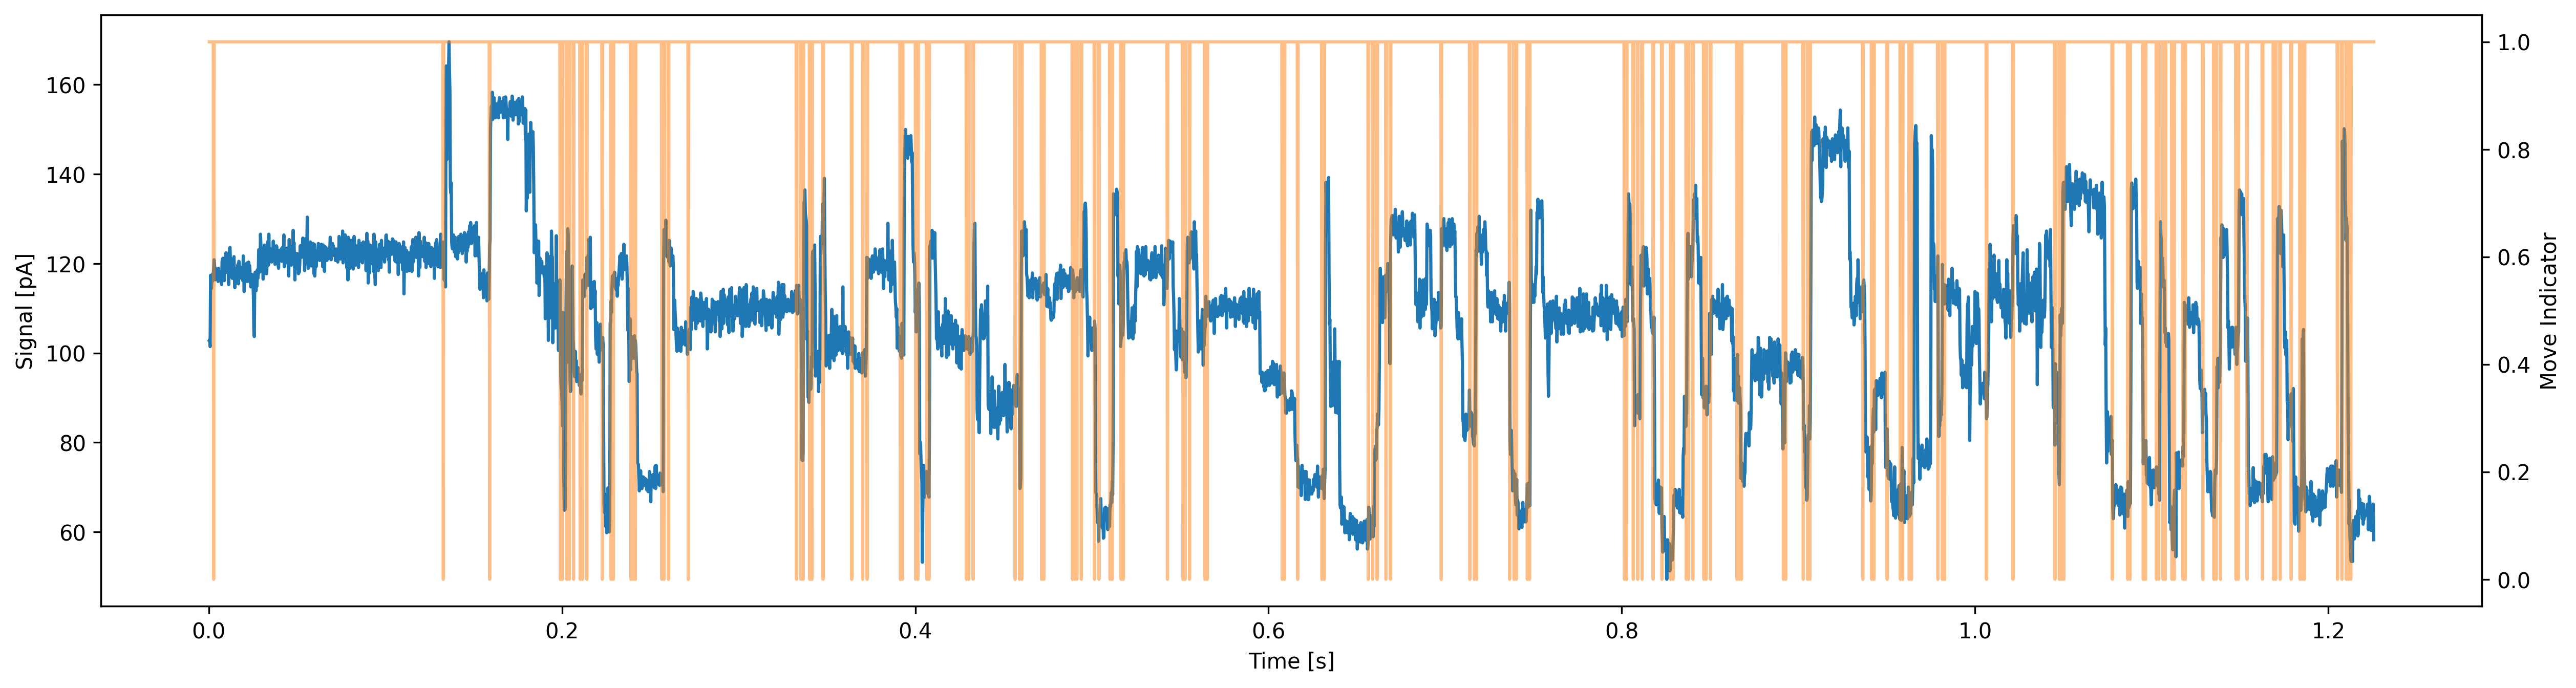

In [93]:

'''
counts_dict = dict(merged_data_df.groupby('ref_name').size())
max(counts_dict, key=counts_dict.get)
'''

print(len(moves_true))
fig, ax = plt.subplots(1, 1, figsize = (20, 5), dpi = 300)

ax.plot(t_sig, sig)
ax.set_ylabel('Signal [pA]')
ax.set_xlabel('Time [s]')
ax2 = ax.twinx()
ax2.plot(t_mv, moves, c='tab:orange', alpha = .5)
ax2.set_ylabel('Move Indicator')

plt.savefig('Move_table_and_signal.png')

